# Optimisation & Simulation: Lab on MCMC methods

**Objective:**
- Use Markov chain Monte Carlo (MCMC) methods to draw from complex distributions.

**Implementation:**
- Gibbs sampling
- Metropolis-Hastings algorithm

**Agenda:**
1. Implement Gibbs sampler to generate draws from bivariate normal.
2. Implement Metropolis-Hastings algorithms to infer posterior distribution of parameters of Cauchy distribution. 

## Gibbs sampling

### Background

**Motivation and intuition:**
- Draw from multivariate distributions from which direct sampling is difficult.
- Construct conditional distributions from which sampling is easy. 
- Iteratively draw from conditional distributions. 


- Suppose we wish to sample $\theta_{1}, \theta_{2} \sim p(\theta_{1}, \theta_{2})$ but cannot do so directly. 
- However, we can sample $\theta_{1} \sim p(\theta_{1} \vert \theta_{2})$ and $\theta_{2} \sim p(\theta_{2} \vert \theta_{1})$.

**Algorithm:**
1. Set $j = 0$. 
2. Provide initial values $(\theta_{1}^{(0)}, \theta_{2}^{(0)})$. 
3. Set $j = j + 1$. 
4. $\theta_{1}^{(j)} \sim p(\theta_{1}^{(j)} \vert \theta_{2}^{(j-1)})$.
5. $\theta_{2}^{(j)} \sim p(\theta_{2}^{(j)} \vert \theta_{1}^{(j)})$.
6. If $j$ is less than the desired number of draws, return to step 3.

### Exercise
- Implement a Gibbs sampler to draw from a bivariate normal, i.e. 
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} (\boldsymbol{\mu}, \boldsymbol{\Sigma})
\text{ with }
\boldsymbol{\mu} = \boldsymbol{0},
\boldsymbol{\Sigma} = 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix},
\rho = 0.8
$$
- Visually compare the empirical density of the draws to the theoretical density of the sampling distribution. 

**Note:**
- If
$$
\begin{pmatrix}
\theta_{1} \\ \theta_{2}
\end{pmatrix}
\sim
\mathcal{N} \left (\boldsymbol{0}, 
\begin{pmatrix}
1 & \rho \\
\rho & 1 
\end{pmatrix}
\right ),
$$
then 
$$
\theta_{1} \vert \theta_{2} \sim \mathcal{N}(\rho \theta_{2}, 1 - \rho^{2}),
$$
$$
\theta_{2} \vert \theta_{1} \sim \mathcal{N}(\rho \theta_{1}, 1 - \rho^{2}).
$$

#### Implementation

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scipy
from scipy.stats import cauchy, gamma, norm, lognorm

In [110]:
def gibbs(rho, theta2, n_draws):
    """ Gibbs sampling of bivariate normal.
    
    Keywords:
        rho (float): correlation parameter.
        theta2 (float): initial value of theta2.
        n_draws (int): number of draws.
    
    Returns:
        theta (array): draws from bivariate normal.
    """
 
    ###
    theta = np.zeros((n_draws, 2))
   

    x2 = theta2
    for i in range(n_draws):
        x1 = np.random.normal(rho * x2, np.sqrt(1 - rho ** 2))
        x2 = np.random.normal(rho * x1, np.sqrt(1 - rho ** 2))
        theta[i, 0] = x1
        theta[i, 1] = x2
    ###
    return theta

In [111]:
rho = 0.8
theta2 = 0
n_draws = 1000

draws = gibbs(rho, theta2, n_draws)
print(draws)

[[ 0.41824277  0.69725114]
 [ 1.3972692   0.94798413]
 [ 2.11233465  0.78532012]
 ...
 [ 0.26511115  0.63608496]
 [-0.93199673 -0.74845331]
 [-0.18971677 -0.24651192]]


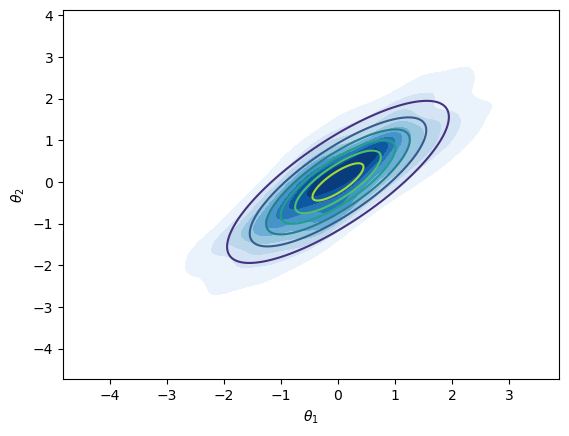

In [122]:
fig = plt.figure()
ax = plt.subplot(1,1,1)

#Theoretical density
mu = np.array([0, 0])
Sigma = np.array([[1, rho], [rho, 1]])
x = np.arange(-3,3,0.01)
xx, yy = np.meshgrid(x,x)
z = scipy.multivariate_normal.pdf(np.stack((xx, yy), axis=2), mu, Sigma)
ax.contour(x, x, z)

#Empirical draws
ax = sns.kdeplot(
    draws[:,0], y=draws[:,1],
    cmap= "Blues" , shade = True
)

ax.set(
    xlabel=r'$\theta_1$',
    ylabel=r'$\theta_2$'
)

plt.show()

## Metropolis-Hastings algorithm

### Background

**Motivation and intuition:**
- Gibbs sampling is only feasible, if the conditional distributions are known and if it is easy to sample from them. 
- The Metropolis-Hastings algorithm allows us to sample from any density $p(\theta)$, provided that we can evaluate $f(\theta)$, a density that is proportional to $p$. 
- At each iteration, we sample a new state from a candidate distribution, which depends on the current state. 
- With some probability depending on the value of the target density at the new and the current states, the new state is accepted. 
- As the algorithm proceeds, the sampled states approximate the desired density. 

**Algorithm:**
1. Set $j = 0$.
2. Let $\theta$ denote the current state.
3. Let $p(\theta \vert x)$ denote the target density.
4. Let $J(\theta^{*} \vert \theta)$ denote the jumping distribution
5. Let $\rho$ denote the step size.
6. Set $j = j + 1$. 
7. Propose a new state $\theta^{*} \vert \theta \sim J(\theta)$.
8. Calculate $\alpha = \frac{p(\theta^{*} \vert x)}{p(\theta \vert x)} \cdot \frac{J(\theta \vert \theta^{*})}{J(\theta^{*} \vert \theta)}$.
9. Draw $r \sim \text{Uniform}(0,1)$.
10. If $r \leq \alpha$, accept the new state and set $\theta = \theta^{*}$. Otherwise, reject the new state. 
11. If $j$ is less than the desired number of draws, return to step 5.

### Exercise 
- Simulate data from Cauchy distribution with location $\mu = 1$ and scale $\gamma = 1$.
- Implement a Metroplis-Hastings algorithms to infer the posterior distribution of the scale parameter of the Cauchy distribution.
- Consider two possible jumping distributions:
- 1. $\text{Normal}(\theta, \rho^2)$, where $\rho$ is the step size.
- 2. $\text{Lognormal}(\log(\theta) - 0.5 \rho^2, \rho)$, where $\rho$ is a distance parameter. Note that $\text{Lognormal}(\mu, \sigma)$ denotes a lognormal distribution with location $\mu$ and scale $\sigma$.
- Evaluate the performance of the algorithms for different parametrisations of the jumping distributions. Compute the potential scale reduction factors $\hat{R}$ and the effective sample size $n_{\text{eff}}$.

Suppose
- $x_{i} \sim \mathcal{C}(\mu, \gamma)$ for $i \in \{1, \dots, N\}$
- $\gamma \sim \text{Gamma}(\alpha_{0}, \beta_{0})$ with $\alpha_{0} = \beta_{0} = 0.001$.

Then
$$
p(\gamma \vert x, \mu, \alpha_{0}, \beta_{0}) 
\propto \left ( \prod_{i} p(x_{i} \vert \mu, \gamma) \right ) p(\gamma \vert \alpha_{0}, \beta_{0})
$$

**Note:**
- PDF of Cauchy distribution:
$$
f(x \vert \mu, \gamma) = \frac{1}{\pi \gamma \left [ 1 + \left (\frac{x - \mu}{\gamma} \right )^{2} \right ]}
$$
- Quantile function of Cauchy distribution:
$$
Q = \mu + \gamma \cdot \text{tan}\left [ \pi \left ( F - \frac{1}{2} \right ) \right ]
$$

#### Cauchy random draws

In [95]:
def cauchy_rng(mu, gamma, n_draws):
    """ Generate cauchy random numbers.
    
    Keywords:
        mu (float): location parameter.
        gamma (float): scale parameter.
        n_draws (int): number of draws.
    
    Returns:
        r (array): n_draws draws from Cauchy(mu, gamma).
    """
    u = np.random.rand(n_draws,)
    r = mu + gamma * np.tan(np.pi * (u - 0.5))
    return r

In [96]:
mu = 1
gamma_true = 1
n_draws = 1000
x = cauchy_rng(mu, gamma_true, n_draws)

#### Normal jumping distribution
##### Implementation

In [97]:
def rhat_n_eff(draws):
    """ Computes potential scale reduction factor and effective sample size.
    
    Keywords:
        draws (1d-array): draws
    
    Returns:
        R (float): potential scale reduction factor.
        n_eff (float): effective sample size.
    """
    #Reshape draws
    psi_cd = np.array(draws).reshape(2,-1)
    C, D = psi_cd.shape
    
    #Rhat
    psi_c = psi_cd.mean(axis=1, keepdims=True)
    psi = psi_c.mean()
    B = D / (C - 1) * np.sum((psi_c - psi)**2) #Between-chain variance
    s2_c = 1 / (D - 1) * np.sum((psi_cd - psi_c)**2, axis=1)
    W = s2_c.mean() #Within-chain variance
    var = (D - 1) / D * W + 1 / D * B
    R = np.sqrt(var / W)
    
    #Effective sample size
    V = lambda t: ((psi_cd[:,t:] - psi_cd[:,:(D-t)])**2).sum() / (C * (D - t)) #Variogram
    negative_autocorr = False
    t = 1
    rho = np.ones(D)
    while not negative_autocorr and (t < D):
        rho[t] = 1 - V(t) / (2 * var)
        if not t % 2:
            negative_autocorr = np.sum(rho[t-1:t+1]) < 0
        t += 1
    n_eff = C * D / (1 + 2 * np.sum(rho[1:t]))
    
    return R, n_eff

In [98]:
def mcmc_normal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with normal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_store (array): accept flags.
    """
    
    # Initialize
    n = len(x)
    gamma = gamma0
    accept = 0
    gamma_store = np.zeros(n_keep)
    accept_store = np.zeros(n_burn + n_keep)

    # Define the log posterior up to a constant
    def log_posterior(gamma):
        if gamma <= 0:
            return -np.inf
        else:
            log_prior = gamma_log_prior(gamma, alpha0, beta0)
            log_likelihood = np.sum(cauchy.logpdf(x, loc=mu, scale=gamma))
            return log_prior + log_likelihood

    # Define the log prior up to a constant
    def gamma_log_prior(gamma, alpha0, beta0):
        return (alpha0 - 1) * np.log(gamma) - beta0 * gamma

    # Run the chain
    for i in range(n_burn + n_keep):
        # Generate a proposal
        gamma_proposal = norm.rvs(loc=gamma, scale=rho)

        # Compute acceptance probability
        log_alpha = log_posterior(gamma_proposal) - log_posterior(gamma)
        alpha = np.exp(log_alpha)

        # Accept or reject proposal
        if np.random.rand() < alpha:
            gamma = gamma_proposal
            accept += 1

        # Store gamma and accept flag
        if i >= n_burn:
            gamma_store[i-n_burn] = gamma
        accept_store[i] = accept / (i + 1)

    return gamma_store, accept_store


      

In [50]:
mu = 1
gamma0 = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000

gamma_store, accept_store = mcmc_normal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep)

In [51]:
gamma_store.mean()

1.0824517792130208

In [52]:
gamma_store.std()

0.04733496567781582

In [53]:
accept_store.mean()

0.512328829459756

In [54]:
rhat_n_eff(gamma_store)

(0.9990078341314368, 330.60969652426235)

In [55]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_normal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

/var/folders/vq/ytz4zzz91ygdwfn57tvlf65h0000gn/T/ipykernel_43186/300989276.py:46: RuntimeWarning: overflow encountered in exp
  alpha = np.exp(log_alpha)


In [56]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,0.101313,0.000151,0.966566,1.665129,2.292420
1,0.00010,0.133403,0.006712,0.807130,2.614087,1.397032
2,0.00100,0.542365,0.039110,0.644806,2.223542,1.647932
3,0.01000,1.051487,0.036393,0.800848,1.021572,17.843193
4,0.10000,1.085142,0.051765,0.488746,0.999672,238.005071
5,0.15000,1.083822,0.042526,0.371801,0.999662,308.939944
6,0.20000,1.082537,0.049948,0.327574,0.999297,154.243582
7,0.25000,1.081574,0.046533,0.243010,1.005242,116.077081
8,0.50000,1.089920,0.044655,0.120629,1.004861,133.790294
9,1.00000,1.082501,0.050805,0.075350,1.074322,38.634120


##### Trace plot

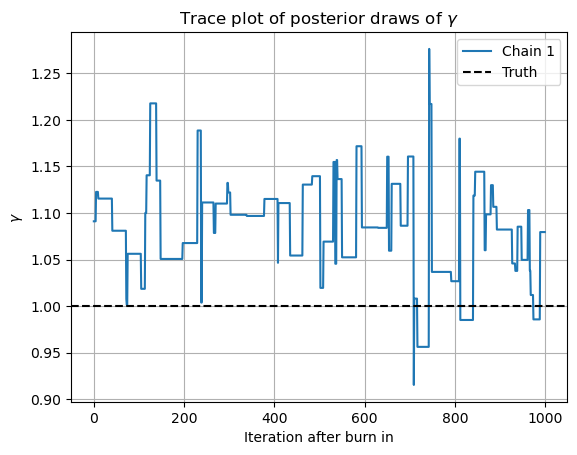

In [57]:
fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()

#### Lognormal jumping distribution
##### Implementation

In [125]:
def mcmc_lognormal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep):
    """ MCMC algorithm with lognormal jumping distribution to estimate posterior of Cauchy scale parameter.
    
    Keywords:
        x (array): data.
        mu (float): Cauchy location parameter.
        gamma (float): Cauchy scale parameter.
        alpha0 (float): Gamma shape, gamma ~ Gamma(alpha0, beta0).
        beta0 (float): Gamma rate, gamma ~ Gamma(alpha0, beta0).
        rho (float): step size.
        n_burn (int): burn in draws.
        n_keep (int): number of draws to keep after burn-in. 
    
    Returns:
        gamma_store (array): gamma draws.
        accept_store (array): accept flags.
    """
    
 # Initialize
    n = len(x)
    gamma = gamma0
    accept = 0
    gamma_store = np.zeros(n_keep)
    accept_store = np.zeros(n_burn + n_keep)

    # Define the log posterior up to a constant
    def log_posterior(gamma):
        if gamma <= 0:
            return -np.inf
        else:
            log_prior = gamma_log_prior(gamma, alpha0, beta0)
            log_likelihood = np.sum(cauchy.logpdf(x, loc=mu, scale=gamma))
            return log_prior + log_likelihood

    # Define the log prior up to a constant
    def gamma_log_prior(gamma, alpha0, beta0):
        return (alpha0 - 1) * np.log(gamma) - beta0 * gamma

    # Run the chain
    for i in range(n_burn + n_keep):
        # Generate a proposal
        gamma_proposal_temp = norm.rvs(loc=np.log(gamma)-0.5*rho**2, scale=np.sqrt(rho))
        gamma_proposal = np.exp(gamma_proposal_temp)

        # Compute acceptance probability
        log_alpha = log_posterior(gamma_proposal) - log_posterior(gamma)
        alpha = np.exp(log_alpha)

        # Accept or reject proposal
        if np.random.rand() < alpha:
            gamma = gamma_proposal
            accept += 1

        # Store gamma and accept flag
        if i >= n_burn:
            gamma_store[i-n_burn] = gamma
        accept_store[i] = accept / (i + 1)

    return gamma_store, accept_store


  

In [126]:
mu = 1
gamma0 = 0.1
alpha0 = 0.001
beta0 = 0.001
rho = 0.1
n_burn = 1000
n_keep = 1000

gamma_store, accept_store = mcmc_lognormal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep)


In [127]:
gamma_store.mean()

1.34888098748333

In [128]:
gamma_store.std()

0.07346924811671451

In [129]:
accept_store.mean()

0.22348158650966835

In [130]:
rhat_n_eff(gamma_store)

(0.9994546119700255, 113.81166480248541)

In [131]:
rho_test = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.15, 0.2, 0.25, 0.5, 1]

gamma_store_all = {}
gamma_mean = []
gamma_std = []
gamma_accept = []
gamma_rhat = []
gamma_n_eff = []

for rho in rho_test:
    gamma_store, accept_store = mcmc_lognormal(x, mu, gamma0, alpha0, beta0, rho, n_burn, n_keep)
    rhat, n_eff = rhat_n_eff(gamma_store)
    
    gamma_store_all[rho] = gamma_store
    gamma_mean.append(gamma_store.mean())
    gamma_std.append(gamma_store.std())
    gamma_accept.append(accept_store.mean())
    gamma_rhat.append(rhat)
    gamma_n_eff.append(n_eff)

In [132]:
results = pd.DataFrame(
    data={
        'rho': rho_test,
        'Post. mean': gamma_mean,
        'Post. std.': gamma_std,
        'Acceptance ratio': gamma_accept,
        'Rhat': gamma_rhat,
        'n_eff': gamma_n_eff
    }
)
results

,rho,Post. mean,Post. std.,Acceptance ratio,Rhat,n_eff
0,0.00001,0.413678,0.095957,0.696124,2.493242,1.462858
1,0.00010,1.338805,0.053938,0.722057,1.015339,18.115823
2,0.00100,1.362311,0.070303,0.725697,1.029872,45.495073
3,0.01000,1.350025,0.068981,0.524159,1.001138,217.793378
4,0.10000,1.352721,0.069421,0.215359,1.014853,75.815525
5,0.15000,1.344002,0.063694,0.176939,1.014522,79.709590
6,0.20000,1.347135,0.058716,0.162211,1.001243,75.662083
7,0.25000,1.330120,0.074893,0.133523,0.999322,119.488953
8,0.50000,1.327535,0.081116,0.090665,1.001168,54.423285
9,1.00000,1.336158,0.061154,0.066599,1.000497,35.371080


##### Trace plot

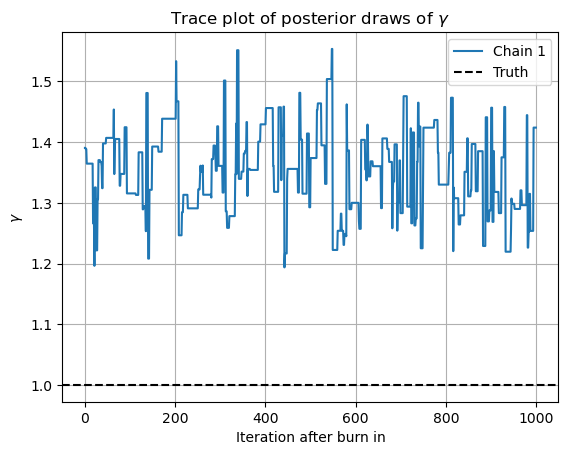

In [133]:
fig, ax = plt.subplots(1,1)
ax.plot(gamma_store_all[0.1], label = 'Chain 1')
plt.axhline(gamma_true, color="black", linestyle="--", label='Truth')

ax.set(xlabel = 'Iteration after burn in', ylabel = r'$\gamma$',
       title= r'Trace plot of posterior draws of $\gamma$')
plt.legend()
ax.grid()